In [1]:
import model as m 
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import scipy

In [2]:
age_class = ["<1", "1-4", "5-9", "10-14", "15-19", "20-29", "30+"]

In [3]:
#Select disease
d = "Measles"

#monthly data
data = pd.read_csv( d +'_data_processed.csv')
monthly_data = data.iloc[:,1:8]
monthly_data = monthly_data[age_class]

#I do not consider 2019
monthly_data = monthly_data.iloc[0:(data.shape[0]-12),:]

time_date = data["Time"][0:(data.shape[0]-12)]

In [4]:
if d== "Mumps":
    years_run = int(time_date[len(time_date)-1]) - int(time_date[0]) +1
    start_yr = int(time_date[0])
    end_yr = int(time_date[len(time_date)-1])
else:
    start_yr = int(time_date[0][0:4])
    end_yr = int(time_date[len(time_date)-1][0:4])
    years_run = int(time_date[len(time_date)-1][0:4]) - int(time_date[0][0:4]) +1

print(start_yr)
print(end_yr)
print(years_run, "--> tmax")

1999
2018
20 --> tmax


### Extracting birth and death rates for age groups:

* Death rates: *death_rate_7_age_groups_1982-2018.csv*: 
$$ d_i = \frac{\text{number of death people who are in i-th age group}}{\text{population in i-th age group}}$$
* Births: *Crude_birth_rate_1938-2018.csv*, unit is birth number per 1000 population
* Population: *population_7_age_groups_1982-2018.csv*

In [5]:
##### Births
Births = pd.read_csv("Data//Crude_birth_rate_1938-2018.csv")

#Select from year 1999 to 2018
if d == "Mumps":
    Births_years = Births.iloc[0:(end_yr-start_yr+1),:]
else:
    Births_years = Births.iloc[0:(end_yr-start_yr+1),:]

#Selecting 3rd column for UK data
Births_years_UK = Births_years.iloc[:,2] 

Births_UK =  Births_years_UK.to_numpy()
#We shall reverse the order to go from 1999 to 2018

Births_UK = np.asarray(list(reversed(Births_UK)))

print(Births_UK)

[11.9 11.5 11.3 11.3 11.7 11.9 12.  12.3 12.6 12.8 12.7 12.9 12.8 12.8
 12.1 12.  11.9 11.8 11.4 11. ]


In [6]:
#### Deaths
Deaths = pd.read_csv("Data//death_rate_7_age_groups_1982-2018.csv")

#exclude last row (no total)
Deaths = Deaths.iloc[0:7,:]

#Selecting columns for years 1999-2018

Deaths_years = Deaths.iloc[:,np.where(Deaths.columns== str(start_yr))[0][0]:np.where(Deaths.columns==str(end_yr))[0][0]+1]

print(Deaths_years)
#Deaths_years.iloc[:,0].to_numpy()

       1999      2000      2001      2002      2003      2004      2005  \
0  0.005762  0.005588  0.005570  0.005346  0.005421  0.005194  0.005126   
1  0.000278  0.000236  0.000233  0.000239  0.000244  0.000231  0.000218   
2  0.000118  0.000117  0.000120  0.000109  0.000111  0.000100  0.000096   
3  0.000151  0.000135  0.000146  0.000142  0.000140  0.000124  0.000137   
4  0.000434  0.000423  0.000422  0.000408  0.000380  0.000376  0.000377   
5  0.000651  0.000653  0.000621  0.000624  0.000603  0.000572  0.000533   
6  0.017067  0.016406  0.016096  0.016069  0.016072  0.015269  0.015122   

       2006      2007      2008      2009      2010      2011      2012  \
0  0.005091  0.004938  0.004751  0.004698  0.004425  0.004371  0.004102   
1  0.000228  0.000227  0.000210  0.000182  0.000182  0.000181  0.000164   
2  0.000102  0.000096  0.000107  0.000093  0.000094  0.000083  0.000089   
3  0.000131  0.000127  0.000101  0.000108  0.000099  0.000089  0.000095   
4  0.000366  0.000351  0

In [7]:
#### Population
Pops = pd.read_csv("Data//population_7_age_groups_1982-2018.csv")

#Just need last row

Pops_tot = Pops.iloc[7,np.where(Deaths.columns==str(start_yr))[0][0]:np.where(Deaths.columns==str(end_yr))[0][0]+1]

#print(Pops_tot)

Pops_tot = np.asarray(Pops_tot)

##### Including real contact matrix from Polymod

- equally weighted one

In [8]:
Poly_7_new = pd.read_csv("Data/Poly_7.csv")
Poly_7_new = Poly_7_new.iloc[:,1:8]
C_poly = Poly_7_new.values

In [9]:
Poly_7_new

,<1,1-4,5-9,10-14,15-19,20-29,30+
0,1.49,1.49,0.59,0.25,0.18,0.515,0.301111
1,0.74,0.74,3.82,0.53,0.44,0.395,0.402222
2,0.36,0.36,0.73,3.19,0.79,0.155,0.308889
3,0.26,0.26,0.22,0.52,3.10,0.485,0.285556
4,0.92,0.92,0.56,0.20,0.58,1.515,0.417778
5,2.94,2.94,2.84,2.21,1.86,1.975,2.127778
6,1.49,1.49,0.59,0.25,0.18,0.515,0.301111


#### Vaccine coverage and Vaccinated IC

In [10]:
Cov_rate = pd.read_csv("Data//" +d +'_vaccine_coverage.csv')
V_ic = Cov_rate.iloc[0:7,1:2]
V_ic = V_ic.to_numpy().reshape((7,))/100
Cov_rate_years = Cov_rate.iloc[0:7,2:21]

# Issue: vaccination rate is up until 2016, now assume 2017-19 are the same?
Cov_rate_years["2017"] = Cov_rate_years["2018"]  = Cov_rate_years["2016"]

Cov_rate_years = Cov_rate_years.iloc[:,np.where(Cov_rate_years.columns== str(start_yr))[0][0]:np.where(Cov_rate_years.columns==str(end_yr))[0][0]+1]
Shift_cov_rate_years = Cov_rate_years.iloc[np.hstack([6, np.arange(0,6)]),:]

In [11]:
para = m.ModelParams(
    age_strucure=[0,1, 5, 10, 15, 20, 30],  #age cuts
    B= lambda t: (Births_UK)[int(np.floor(t))],  #births rate per capita
    V=lambda t: (Shift_cov_rate_years.to_numpy()/100.0)[:, (int(np.floor(t))-1)],
    d=lambda t: Deaths_years.to_numpy()[:, int(np.floor(t))],  #death rate
    gamma=(1/14.0*365.0)*np.ones([7]),
    C=C_poly*365,
    N= lambda t: Pops_tot[int(np.floor(t))]
)
pop_scale = 1000 #Set scale to cases per 1000 

Each age group IC is weighted by their percetange at first year pop

In [12]:
age_struct_start = np.asarray(Pops[str(start_yr)][0:7]/np.sum(Pops[str(start_yr)][0:7]))

In [56]:
S_ic = np.hstack([(0*((np.ones(7)-V_ic)[0:1])),((0.5-1e-8)*((np.ones(7)-V_ic)[1:2])), (0.01*((np.ones(7)-V_ic)[2:5])), (0*((np.ones(7)-V_ic)[5:7]))])
I_ic = np.hstack([(1e-8*((np.ones(7)-V_ic)[0])), (1e-9*((np.ones(7)-V_ic)[1:5])), (0*((np.ones(7)-V_ic)[5:7]))]) 
R_ic = (np.ones(7) - S_ic - I_ic - V_ic)
new_ic = np.hstack([S_ic, I_ic, R_ic, V_ic])

In [57]:
norm_ic = np.hstack([new_ic[0:7]*age_struct_start,  
                    new_ic[7:14]*age_struct_start,
                    new_ic[14:21]*age_struct_start,
                    new_ic[21:28]*age_struct_start])*pop_scale
print(norm_ic)

[0.00000000e+00 2.70521145e+00 2.03759705e-02 5.24271161e-03
 2.22407015e-01 0.00000000e+00 0.00000000e+00 1.20049144e-07
 5.41042302e-09 2.03759705e-09 5.24271161e-10 2.22407015e-08
 0.00000000e+00 0.00000000e+00 1.20049143e+01 2.70521156e+00
 2.01722108e+00 5.19028449e-01 2.20182945e+01 6.45290444e+01
 6.16088119e+02 0.00000000e+00 4.39434928e+01 6.36767422e+01
 6.46976025e+01 3.95390249e+01 6.53080671e+01 0.00000000e+00]


In [58]:
beta = 3*np.eye(7)*[0.9,0.2,0.9,0.5,0.5,0.5,0.5] #This scales with time (to check compute r0)!
mdl = m.SIRVModel(para, lambda t: beta)

In [59]:
out, t, out_YN = mdl.run(norm_ic ,t_max = years_run-0.00001, method="Radau", eval_per_year=1200, pop_scale=pop_scale)

In [60]:
out[7:14,1]

array([1.18503853e-07, 7.32795781e-08, 3.37995684e-09, 8.28780564e-10,
       3.80826239e-08, 0.00000000e+00, 0.00000000e+00])

Text(0.5, 1.0, 'Infected curve for all age groups (unnormalized)')

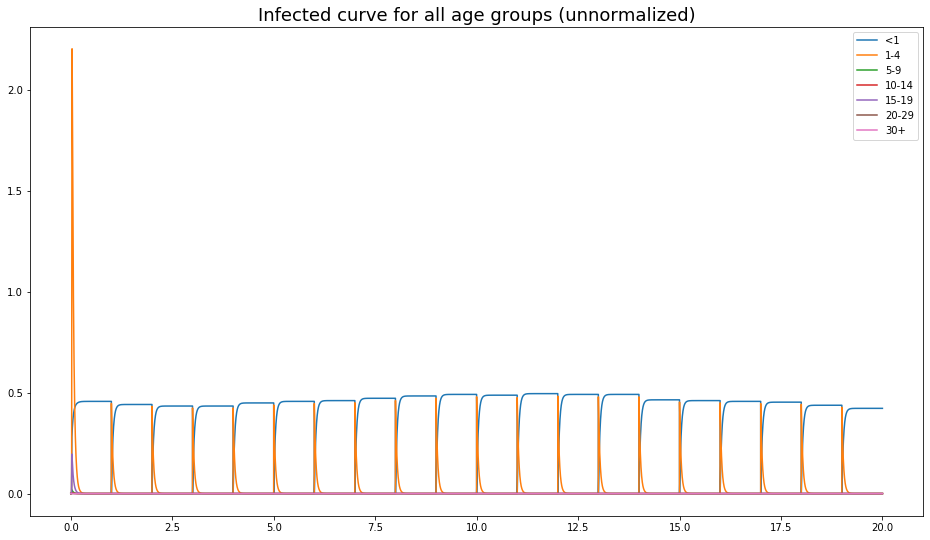

In [61]:
Inf_OUT = out[7:(7*2),:]
plt.figure(figsize=(16,9))
for ii in range(7):
    plt.plot(t[0:len(t)], np.transpose(out[7+ii,0:len(t)]), label = age_class[ii])
plt.legend()
plt.title("Infected curve for all age groups (unnormalized)", fontsize = 18)

#### Plotting the scaled infected by normalising pop

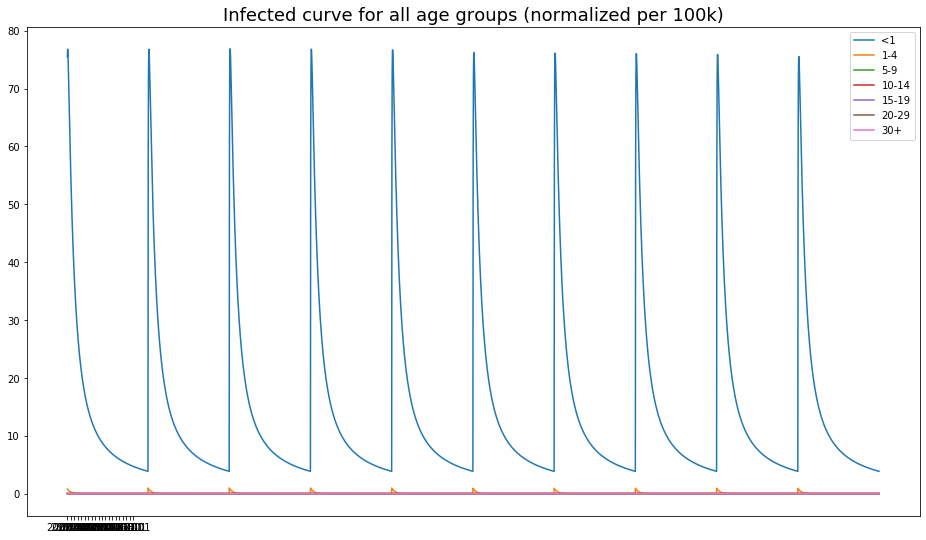

In [81]:
Inf_OUT = out[7:(7*2),:]
plt.figure(figsize=(16,9))
for ii in range(7):
    tot = np.sum(out[np.array([0,7,14,21])+ii,], axis=0)
    plt.plot(t[12000:len(t)], (np.transpose(out[7+ii,]) / tot)[12000:len(t)]*100, label = age_class[ii])
plt.legend()
if d == "Mumps":
    plt.xticks(t[12000:len(t)][np.arange(years_run)*51], time_date)
else:
    plt.xticks(t[12000:len(t)][np.arange(years_run)*51], time_date[np.arange(1, years_run)*12])

plt.title("Infected curve for all age groups (normalized per 100k)", fontsize = 18)

if d == "Mumps":
    plt.savefig("Inf_sim_"+d+"_noOpt.svg")

# plt.figure(figsize=(16,9))
for ii in range(7):
    plt.plot(t, np.transpose(out[21+ii,:]/(out[0+ii,:]+out[7+ii,:]+out[14+ii,:]+out[21+ii,:])), label = age_class[ii])
plt.legend()

plt.title("Vaccinated curve for all age groups (unnormalized)", fontsize = 18)

In [ ]:
monthly_data_cut = monthly_data.iloc[0:(monthly_data.shape[0]-12),:]

In [78]:
def get_yearly_rates(Y_N, eval_per_year, n_years):
        return np.diff(Y_N[:,np.linspace(0, (eval_per_year-1)*n_years, n_years, dtype=np.int32)])

def get_monthly_rates(Y_N, eval_per_year, n_years):
        return np.diff(Y_N[:,np.linspace(0, (eval_per_year-1)*n_years, 12*n_years, dtype=np.int32)])
                       
def f_ssq(beta_vec):
    n_eval=12000
    beta = np.eye(7)*np.abs(beta_vec)
    mdl = m.SIRVModel(para, lambda t: beta)
    if d == "Mumps":
        out, t, out_YN = mdl.run(norm_ic ,t_max = years_run-0.0001,method="Radau", eval_per_year=n_eval)
        new_inf = get_yearly_rates(out_YN, n_eval, years_run)
    else:
        out, t, out_YN = mdl.run(norm_ic ,t_max = years_run-0.0001,method="Radau", eval_per_year=n_eval)
        new_inf = get_monthly_rates(out_YN, n_eval, years_run)
    
    ssq = np.sum(np.sum((new_inf-np.reshape(monthly_data[age_class].to_numpy()[0:-1], (7,-1))*1e-5)**2))
    return ssq

In [79]:
fit_measles = scipy.optimize.fmin(f_ssq, x0 = 5*np.array([0.5,0.5,0.5,0.5,0.5,0.5,0.5]), xtol=1e-6
                                  ,maxiter = 1700, maxfun = 1700, full_output=1)

0.011325682581428964
128.24339522743082
128.2320695448494


KeyboardInterrupt: 

In [ ]:
beta_optimized_measles = fit_measles[0]

In [ ]:
beta_optimized_measles 

In [ ]:
#fit_measles = scipy.optimize.fmin(f_ssq, x0 = np.array([0.9, 0.9, 0.8, 0.8, 0.7, 0.7, 0.6]), xtol=0.0001,maxiter = 1000, maxfun = 1,full_output=1)

In [ ]:
#fit_measles[0]

### Plotting the final estimation

In [ ]:
beta = np.eye(7)*beta_optimized_measles
mdl = m.SIRVModel(para, lambda t: beta)
out, t, yin = mdl.run(new_ic ,t_max = years_run-0.0001,method="Radau", eval_per_year=12000)

In [ ]:
Inf_OUT = out[7:(7*2),:]
plt.figure(figsize=(16,9))
for ii in range(7):
    tot = np.sum(out[np.array([0,7,14,21])+ii,], axis=0)
    plt.plot(t[0:len(t)], (np.transpose(yin[ii,]))[0:len(t)]*100000,label = age_class[ii])
plt.legend()
plt.xticks(t[0:len(t)][np.arange(years_run)*51], time_date[np.arange(1, years_run)*12])
plt.title("Infected curve for all age groups (normalized per 100k)", fontsize = 18)

plt.savefig("Infected_sim_"+d + ".svg")

In [ ]:
(Cov_rate_years.to_numpy()/100)[:,1]